# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw
import os

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import BCEWithLogitsLoss
import torch.optim as optim
from torch.optim import lr_scheduler

import random
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        file_list = os.listdir(path=images_dir)
        self.images = []
        self.length = 0
        for x in file_list:
            img = Image.open(images_dir + x)
            mask = Image.open(target_dir + x[:-4] + ".png")
            tensor_img = transforms[-2](img)
            tensor_mask = transforms[-2](mask)
            self.images.append((transforms[-1](tensor_img), tensor_mask))
            self.length += 1
            for transform in transforms[:-2]:
                item = transform(img, mask)
                if item is not None:
                    tensor_image = transforms[-2](item[0])
                    tensor_mask = transforms[-2](item[1])
                    self.images.append((transforms[-1](tensor_image), tensor_mask))
                    self.length += 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        if self.length > idx:
            return self.images[idx]
        else:
            raise IndexError


## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [ ]:
class HorizontalFlip(object):
    def __init__(self, mode=0.5):
        self.method = mode

    def __call__(self, img, mask):
        x = random.random()
        if x <= self.method:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            return (img, mask)
        return None


class CutFragment(object):
    def __init__(self, mode=0.5):
        self.method = mode

    def __call__(self, img, mask):
        w, h = img.size
        w_del = random.randint(0, w) // 4
        h_del = random.randint(0, h) // 4
        p = random.random()
        x = random.randint(0, w - w_del)
        y = random.randint(0, h - h_del)
        if p <= self.method:
            tmp = img.copy()
            idraw = ImageDraw.Draw(tmp)
            idraw.rectangle((x, y, x + w_del, y + h_del), fill='black')
            return (tmp, mask)
        return None


class BrightnessChange(object):
    def __init__(self, mode=0.5):
        self.method = mode

    def __call__(self, img, mask):
        factor = random.random() / 3 + 0.3
        x = random.random()
        if x <= self.method:
            return (ImageEnhance.Brightness(img).enhance(factor), mask)
        return None


class ChangeBackground(object):
    def __init__(self, path, mode=0.5):
        self.method = mode
        self.path = path
        self.back_list = os.listdir(path=path)

    def __call__(self, img, mask):
        new_bg = Image.open(self.path + self.back_list[random.randint(0, len(self.back_list) - 1)])
        x = random.random()
        if x <= self.method:
            return (Image.composite(img, new_bg, mask), mask)
        return None


Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [ ]:
DATA_PATH = "/content/drive/MyDrive/"

train_dataset = PhotosDataset(
    images_dir = DATA_PATH + "train/", 
    target_dir = DATA_PATH + 'train_mask/',
    transforms = [HorizontalFlip(), CutFragment(), BrightnessChange(), 
                  ChangeBackground(path=DATA_PATH + "background/"), 
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225])]
)

test_dataset = PhotosDataset(
    images_dir = DATA_PATH + 'test/',
    target_dir = DATA_PATH + 'test_mask/',
    transforms = [HorizontalFlip(), CutFragment(), BrightnessChange(), 
                  ChangeBackground(path=DATA_PATH + "background/"), 
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225])]
)

Функция для отображения изображения:

In [ ]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

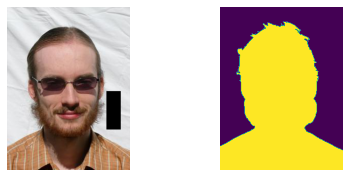

In [ ]:
show_idx_image(train_dataset, 11)

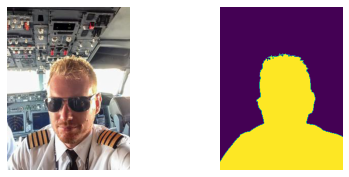

In [ ]:
show_idx_image(train_dataset, 4)

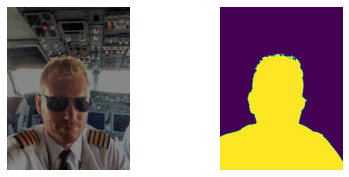

In [ ]:
show_idx_image(train_dataset, 5)

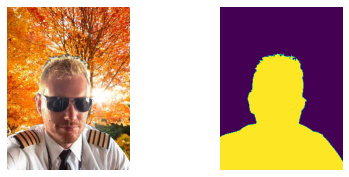

In [ ]:
show_idx_image(train_dataset, 6)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        true_labels = true_labels.long()

        if self.with_logits:
            logits = torch.sigmoid(logits)

        dice = 1 - 2 * torch.sum(logits * true_labels, dim=(1, 2)) / torch.sum(logits + true_labels + self.eps, dim=(1, 2))

        if self.reduction == 'sum':
            loss_value = torch.sum(dice)
        elif self.reduction == 'mean':
            loss_value = torch.mean(dice)
        elif self.reduction is None:
            loss_value = dice

        return loss_value

Проверка реализации:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [ ]:
def IoU(y_pred, y_true):
  pred = torch.sigmoid(y_pred)
  inter = y_true * pred
  union = torch.sum(y_true + pred - inter)
  inter = torch.sum(inter)
  return inter / union

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.

    with torch.no_grad():
        for data in testloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())

    mean_loss = loss / total
    metric = correct / total

    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [ ]:
def show_image(img_tuple):
    image_to_show = img_tuple[0].cpu().transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = img_tuple[1][0].cpu().numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

In [ ]:
def train(model):
    loss_array = []
    score_array = []
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        mean_loss, metric = evaluate_net(model, test_data_loader, 
                                         criterion, val_criterion, device)
        print(f'Loss for epoch {epoch}: {mean_loss}')
        print(f'Score {epoch}: {metric}')
        loss_array.append(mean_loss)
        score_array.append(metric)

    torch.save(model, 'path_to_model.pth')
    return loss_array, score_array

In [ ]:
num_epoch = 10
lr = 1e-3
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = BCEWithLogitsLoss()
val_criterion = IoU
print(device)

cuda:0


In [ ]:
BCE_loss_array, IoU_score_array = train(model)

Loss for epoch 0: 0.06978936518410699
Score 0: 0.08007753424221377
Loss for epoch 1: 0.0369595629777268
Score 1: 0.09181499995773645
Loss for epoch 2: 0.03001029600056527
Score 2: 0.0976135020347522
Loss for epoch 3: 0.025659643417353824
Score 3: 0.10651898512737357
Loss for epoch 4: 0.025590675224145824
Score 4: 0.10885067809399941
Loss for epoch 5: 0.023113483147655458
Score 5: 0.11117404170459409
Loss for epoch 6: 0.025185407985814756
Score 6: 0.10983459111883771
Loss for epoch 7: 0.026213186125246455
Score 7: 0.11109675020336819
Loss for epoch 8: 0.02967868719419701
Score 8: 0.11119169397033947
Loss for epoch 9: 0.03358218753688055
Score 9: 0.1104776300400567



In [ ]:
model = model.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        break

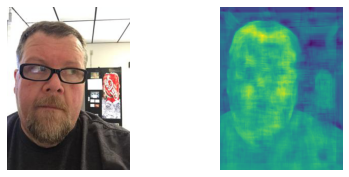

In [ ]:
show_image((images[1], outputs[1]))

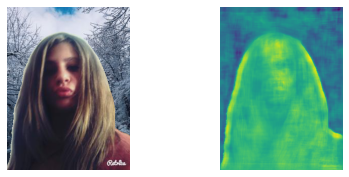

In [ ]:
show_image((images[5], outputs[5]))

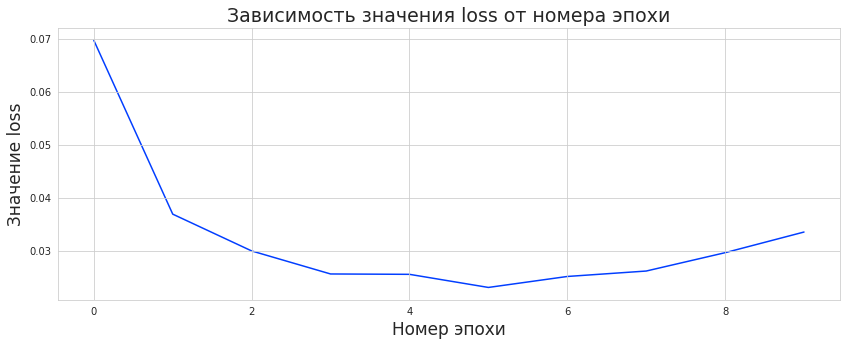

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(BCE_loss_array)), BCE_loss_array)

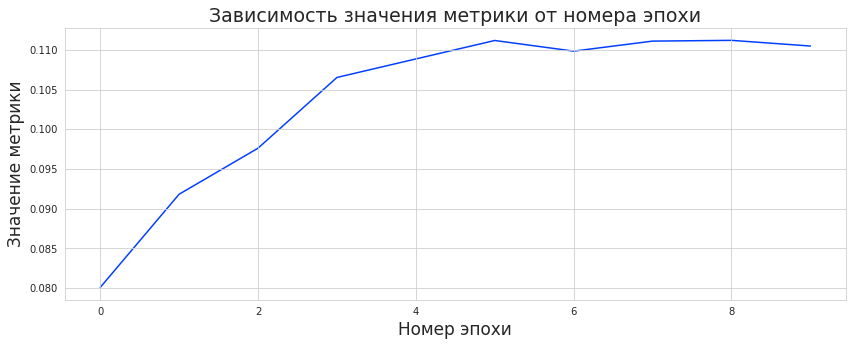

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(IoU_score_array)), IoU_score_array)

In [ ]:
num_epoch = 10
lr = 1e-5
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = DiceLoss(reduction='mean')
val_criterion = IoU
print(device)

cuda:0


In [ ]:
Dice_loss_array, Dice_IoU_score_array = train(model)

Loss for epoch 0: 0.020339953858289215
Score 0: 0.10844272818210886
Loss for epoch 1: 0.018967453385893104
Score 1: 0.1111884395853221
Loss for epoch 2: 0.018386564407345773
Score 2: 0.11214541216834271
Loss for epoch 3: 0.017807807317740624
Score 3: 0.11321274010683421
Loss for epoch 4: 0.017438052985951198
Score 4: 0.11362859056436186
Loss for epoch 5: 0.01732386701362882
Score 5: 0.1138944637289436
Loss for epoch 6: 0.01708457890978391
Score 6: 0.11427730093185279
Loss for epoch 7: 0.017070644385487343
Score 7: 0.11432064994633627
Loss for epoch 8: 0.01705190575094246
Score 8: 0.11438263806221868
Loss for epoch 9: 0.016993324368370238
Score 9: 0.11444786955698502



In [ ]:
model = model.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        break

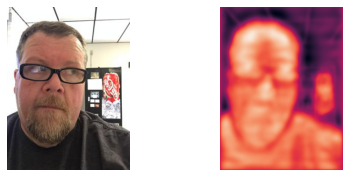

In [ ]:
show_image((images[1], outputs[1]))

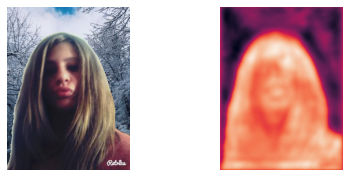

In [ ]:
show_image((images[5], outputs[5]))

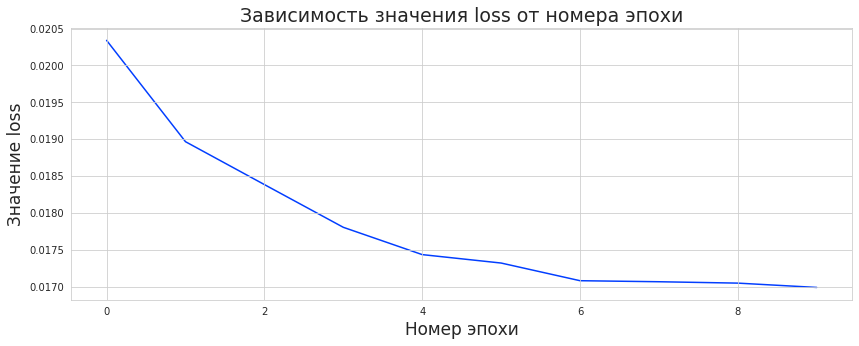

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Dice_loss_array)), Dice_loss_array)

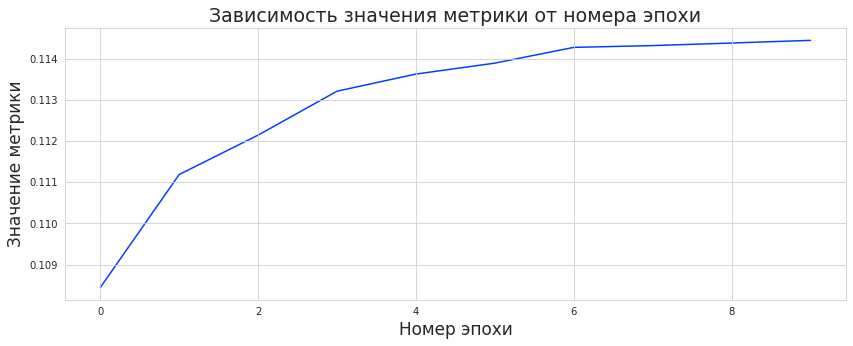

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Dice_IoU_score_array)), Dice_IoU_score_array)

In [ ]:
class SumLosses(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
      super().__init__()
      self.DiceLoss = DiceLoss(eps=eps, reduction=reduction, 
                               with_logits=with_logits)
      self.BCE = BCEWithLogitsLoss()

    def forward(self, logits, true_labels):
      return (self.DiceLoss.forward(logits, true_labels) + self.BCE.forward(logits, true_labels)) / 2


In [ ]:
num_epoch = 10
lr = 1e-5
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = SumLosses(reduction='mean')
val_criterion = IoU
print(device)

cuda:0


In [ ]:
sum_loss_array, sum_IoU_score_array = train(model)

Loss for epoch 0: 0.025289720321873682
Score 0: 0.10580163050612672
Loss for epoch 1: 0.02255172185081658
Score 1: 0.10842042932693335
Loss for epoch 2: 0.021244990239612203
Score 2: 0.10996401767364794
Loss for epoch 3: 0.02063110935316383
Score 3: 0.11154621396419241
Loss for epoch 4: 0.020090345105678916
Score 4: 0.11190492500790017
Loss for epoch 5: 0.02035513634590222
Score 5: 0.11131359018581949
Loss for epoch 6: 0.019917763778560166
Score 6: 0.11221809524426357
Loss for epoch 7: 0.020023212756970516
Score 7: 0.11198881604402756
Loss for epoch 8: 0.020224758207226256
Score 8: 0.11212382613897895
Loss for epoch 9: 0.019989348501324368
Score 9: 0.11246236108189864



In [ ]:
model = model.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        break

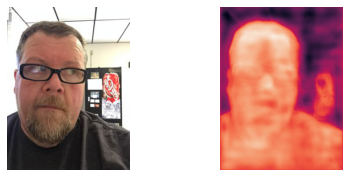

In [ ]:
show_image((images[1], outputs[1]))

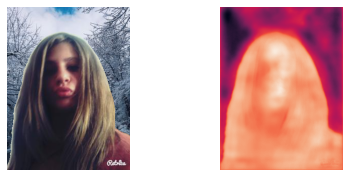

In [ ]:
show_image((images[5], outputs[5]))

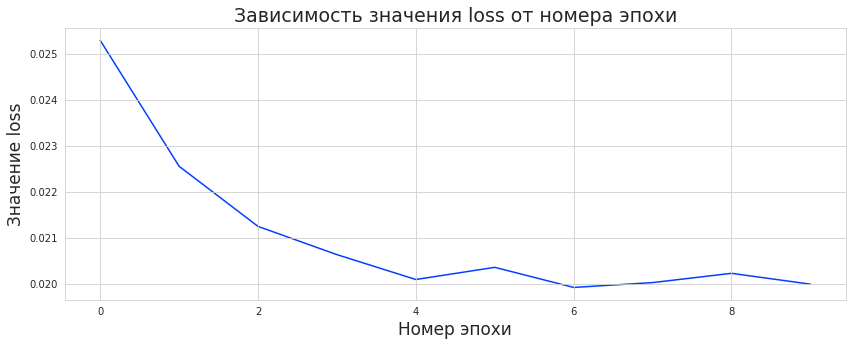

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(sum_loss_array)), sum_loss_array)

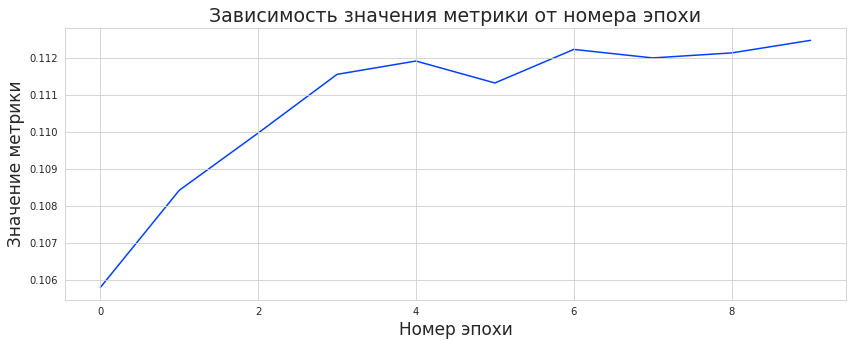

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(sum_IoU_score_array)), sum_IoU_score_array)

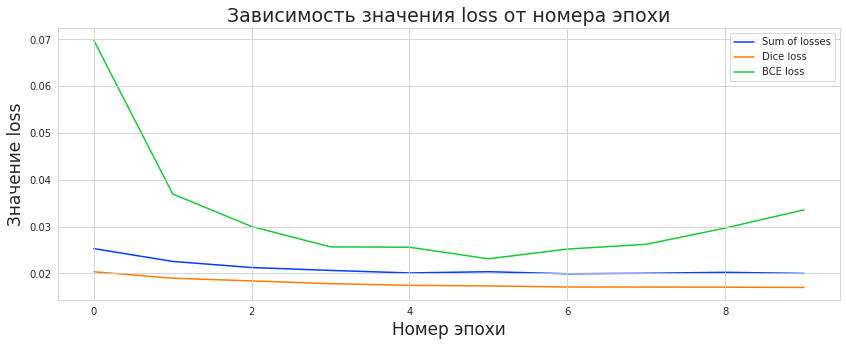

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(sum_loss_array)), sum_loss_array, label='Sum of losses')
ax1.plot(np.arange(len(Dice_loss_array)), Dice_loss_array, label='Dice loss')
ax1.plot(np.arange(len(BCE_loss_array)), BCE_loss_array, label='BCE loss')
ax1.legend()

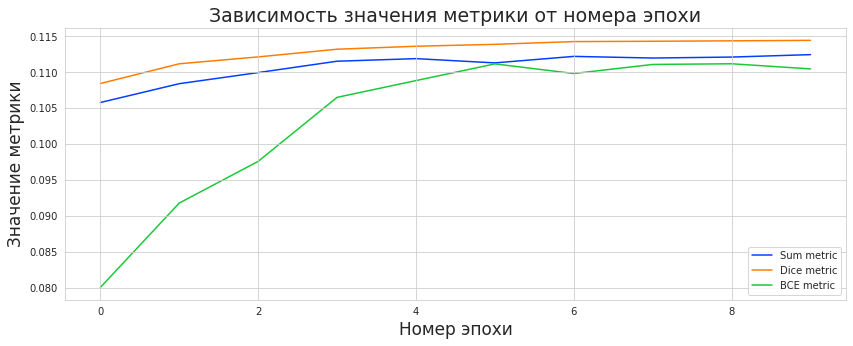

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(sum_IoU_score_array)), sum_IoU_score_array, 
         label='Sum metric')
ax1.plot(np.arange(len(Dice_IoU_score_array)), Dice_IoU_score_array, 
         label='Dice metric')
ax1.plot(np.arange(len(IoU_score_array)), IoU_score_array, 
         label='BCE metric')
ax1.legend()

В целом, все три модели показывают неплохой результат предсказания. Построенные по изображениям маски правильно сегментированы. Можно заметить, что модель, обученная на BCEWeighted, немного хуже по качеству и дольше сходится к приемлемому результату.

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [ ]:
class NewDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(x + left))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class NewDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', NewDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = NewDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

In [ ]:
num_epoch = 10
lr = 1e-3
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LinkNet()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = BCEWithLogitsLoss()
val_criterion = IoU
print(device)

cuda:0


In [ ]:
Link_BCE_loss_array, Link_IoU_score_array = train(model)

Loss for epoch 0: 0.05210381097948322
Score 0: 0.08126522908703639
Loss for epoch 1: 0.0461802461829323
Score 1: 0.08451217026091538
Loss for epoch 2: 0.041786521494102016
Score 2: 0.08512874692678452
Loss for epoch 3: 0.03982630730248415
Score 3: 0.08855752245737956
Loss for epoch 4: 0.03917208564682649
Score 4: 0.08968769902220139
Loss for epoch 5: 0.03962275643761341
Score 5: 0.08745857801001805
Loss for epoch 6: 0.03863973267233142
Score 6: 0.09067442225149044
Loss for epoch 7: 0.038356867332298025
Score 7: 0.09160512442199084
Loss for epoch 8: 0.037972556248020664
Score 8: 0.09101688747222607
Loss for epoch 9: 0.03794224972191911
Score 9: 0.09156205891989745



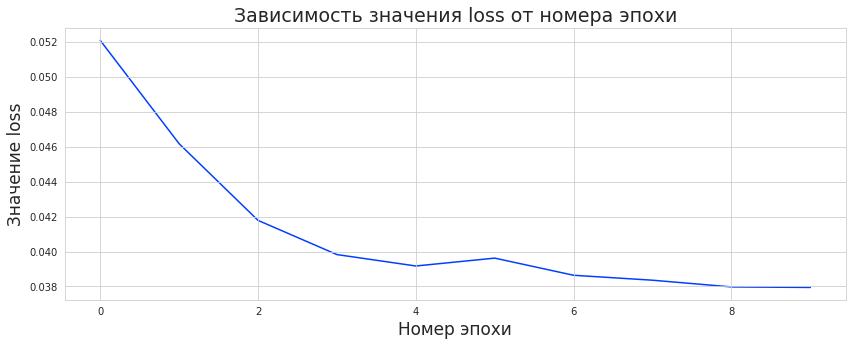

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_BCE_loss_array)), Link_BCE_loss_array)

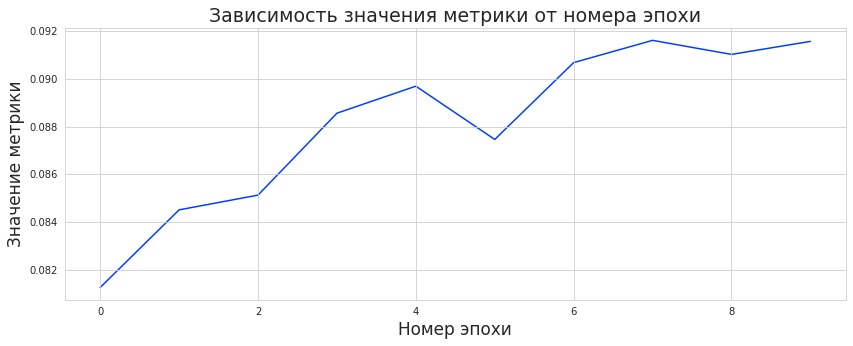

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_IoU_score_array)), Link_IoU_score_array)

In [ ]:
model = model.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        break

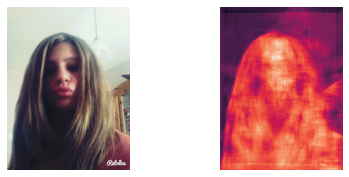

In [ ]:
show_image((images[1], outputs[1]))

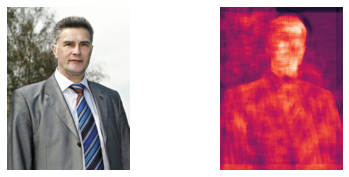

In [ ]:
show_image((images[6], outputs[6]))

In [ ]:
num_epoch = 10
lr = 1e-5
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LinkNet()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = DiceLoss(reduction='mean')
val_criterion = IoU
print(device)

cuda:0


In [ ]:
Link_Dice_loss_array, Link_Dice_IoU_score_array = train(model)

Loss for epoch 0: 0.020590804365033712
Score 0: 0.10587461708256832
Loss for epoch 1: 0.018714245444593523
Score 1: 0.1093814900288215
Loss for epoch 2: 0.01812041266552674
Score 2: 0.1105112275825097
Loss for epoch 3: 0.01769849557716113
Score 3: 0.11111515731765674
Loss for epoch 4: 0.017395010428467337
Score 4: 0.11168248249361148
Loss for epoch 5: 0.01731774997181044
Score 5: 0.1119238085185106
Loss for epoch 6: 0.017210036762452755
Score 6: 0.1120877294586255
Loss for epoch 7: 0.017135148379915897
Score 7: 0.11218592166327514
Loss for epoch 8: 0.017090629947443422
Score 8: 0.11227352229448465
Loss for epoch 9: 0.017040750132694554
Score 9: 0.11235380788835195



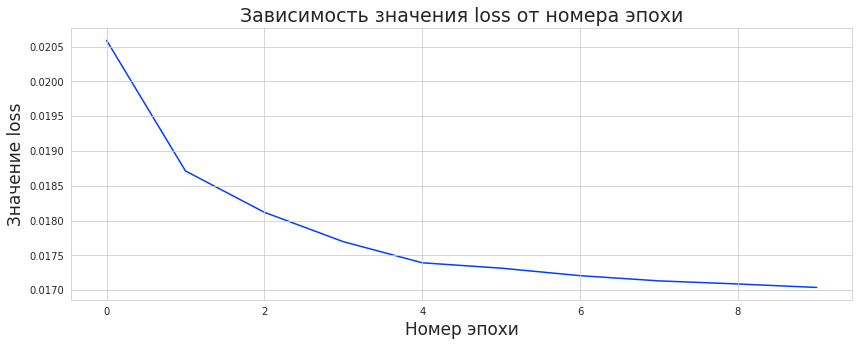

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_Dice_loss_array)), Link_Dice_loss_array)

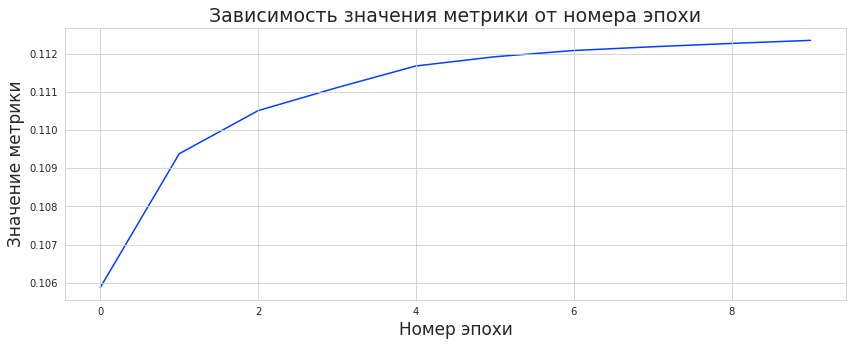

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_Dice_IoU_score_array)), Link_Dice_IoU_score_array)

In [ ]:
model = model.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        break

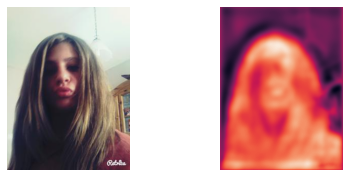

In [ ]:
show_image((images[1], outputs[1]))

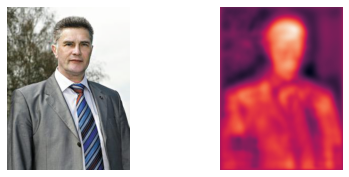

In [ ]:
show_image((images[6], outputs[6]))

In [ ]:
num_epoch = 10
lr = 1e-5
step_size = 2
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LinkNet()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = SumLosses(reduction='mean')
val_criterion = IoU
print(device)

cuda:0


In [ ]:
Link_sum_loss_array, Link_sum_IoU_score_array = train(model)

Loss for epoch 0: 0.024047729666703023
Score 0: 0.10369749567829646
Loss for epoch 1: 0.021977817818809014
Score 1: 0.10668990302544373
Loss for epoch 2: 0.02070787193504377
Score 2: 0.10865288987182654
Loss for epoch 3: 0.01981044032324392
Score 3: 0.10946352006151126
Loss for epoch 4: 0.019519030071723346
Score 4: 0.10962042140846069
Loss for epoch 5: 0.01935722936804478
Score 5: 0.109798642878349
Loss for epoch 6: 0.019328228986034028
Score 6: 0.11065935314847873
Loss for epoch 7: 0.019556517927692488
Score 7: 0.10972543261372127
Loss for epoch 8: 0.019307430403736923
Score 8: 0.11025263841908711
Loss for epoch 9: 0.019427496357820928
Score 9: 0.11019353324977252



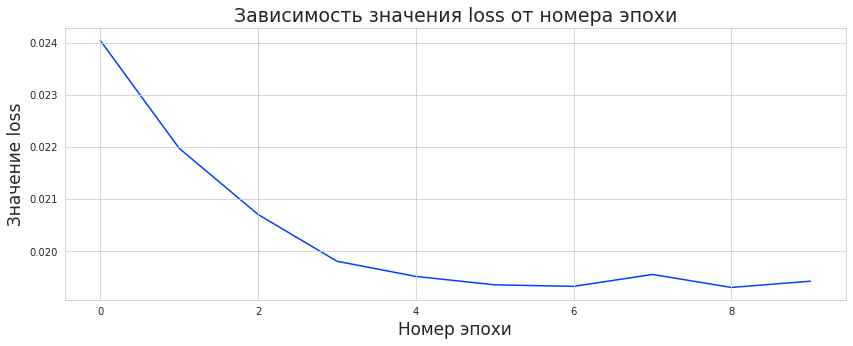

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_sum_loss_array)), Link_sum_loss_array)

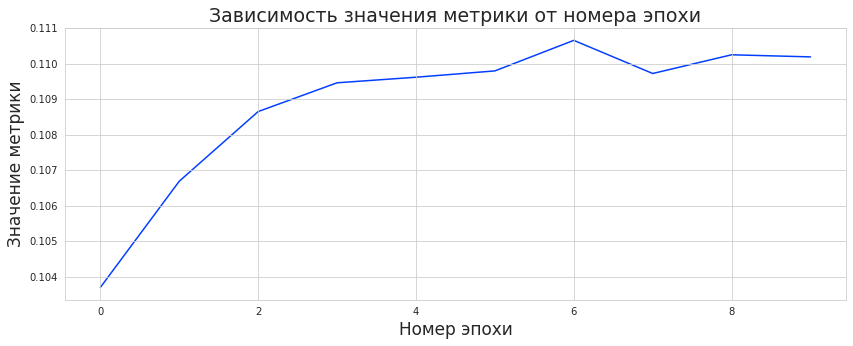

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17)
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_sum_IoU_score_array)), Link_sum_IoU_score_array)

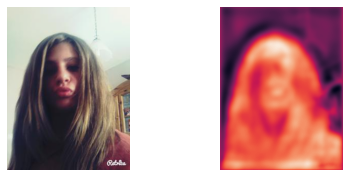

In [ ]:
show_image((images[1], outputs[1]))

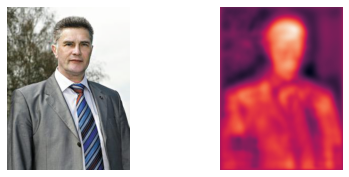

In [ ]:
show_image((images[6], outputs[6]))

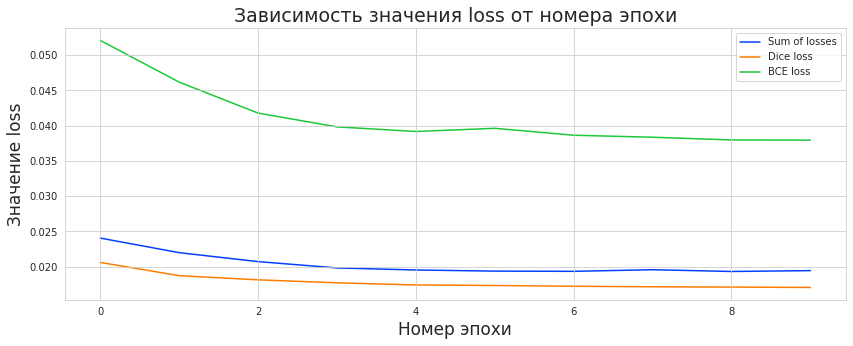

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения loss от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение loss", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_sum_loss_array)), Link_sum_loss_array, 
         label='Sum of losses')
ax1.plot(np.arange(len(Link_Dice_loss_array)), Link_Dice_loss_array, 
         label='Dice loss')
ax1.plot(np.arange(len(Link_BCE_loss_array)), Link_BCE_loss_array, 
         label='BCE loss')
ax1.legend()

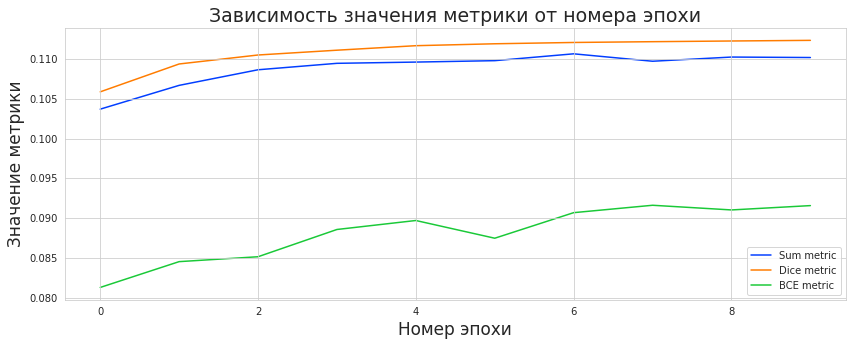

In [ ]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.title("Зависимость значения метрики от номера эпохи", fontsize = 19)
plt.xlabel("Номер эпохи", fontsize = 17) 
plt.grid(which='minor')
plt.ylabel("Значение метрики", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(np.arange(len(Link_sum_IoU_score_array)), Link_sum_IoU_score_array, 
         label='Sum metric')
ax1.plot(np.arange(len(Link_Dice_IoU_score_array)), Link_Dice_IoU_score_array, 
         label='Dice metric')
ax1.plot(np.arange(len(Link_IoU_score_array)), Link_IoU_score_array, 
         label='BCE metric')
ax1.legend()

Как и в случае UNet, наилучшие показатели достигаются при использовании DiceLoss. При этом, UNet показывает лучшее качество и меньшее значение loss.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

Сверточная нейронная сеть предполагает получение на вход изображения. Т.е. объект должен быть трехмерным, признаки предполагаются локально связанными и присутствует совместное разделение параметров (локальная связность - попиксельно. Т.е. если в этом пикселе собачка, то и в соседнем скорее всего будет собачка). Преимущества: уменьшение количества параметров. Мне кажется, примером входных данных может быть почти все, что не является изображением.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. Т.к. ${\sigma(\cdot)}$ - поэлементная функция, она не меняет размерность выходного пространства. Получается, на его размер повлияет только операция умножения матрицы на вектор. Размерность $W$ - ${1000\times 100}$, $x$ - вектор размера ${100\times 1}$. Получаем выходное пространство размерности ${1000\times 1}$. Теперь рассмотрим ${g(\cdot)}$. Т.к. свертка размерности 3 с паддингом 1, на выходе получаем ту же размерность, что и на входе. Т.к. карт признаков десять, получаем выходной слой ${10\times 100}$.
2. Для ${f(\cdot)}$ обучаемыми параметрами являются веса матрицы. Получаем ${1000\times 100} = 100000$ обучаемых параметров. Для ${g(\cdot)}$ обучаемыми параметрами являются веса 10 сверток размерности 3, т.е. 30 параметров.
3. Если считать сигмоиду одной операцией, то получаем 1000 сигмоид для одного выходного вектора (если делить на операции, то в каждой сигмоиде их 3: возведение в степень, сложение, деление). Теперь посмотрим количество операций для произведения матрицы весов на вектор. Для каждой строки матрицы будет произведено 100 умножений и 99 сложений. Т.е. всего 199000 операций. И плюсуем сигмоиду в зависимости от того, сколько в ней операций считать (1000 или 3000).

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.